In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import scipy as sp
import numpy as np

In [2]:
df_train = pd.read_csv('../data/raw/actuarial-loss-estimation/train.csv', parse_dates=['DateTimeOfAccident', 'DateReported'])

In [3]:
df_train.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09 07:00:00+00:00,2002-07-05 00:00:00+00:00,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6982224,1999-01-07 11:00:00+00:00,1999-01-20 00:00:00+00:00,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5481426,1996-03-25 00:00:00+00:00,1996-04-14 00:00:00+00:00,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9775968,2005-06-22 13:00:00+00:00,2005-07-22 00:00:00+00:00,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2634037,1990-08-29 08:00:00+00:00,1990-09-27 00:00:00+00:00,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


### Some observations
* ClaimNumber seems the identifier
* DateReported - DateTimeOfAccident = time to report claim
* Numeric: Age, DependentChildre, DependentsOther, WeeklyWages, HowrsWorkedPerWeek, DaysWorkedPerWeek, InitialIncurredClaimsCost
* Categories: Gender, MaritalStatus, PartTimeFullTime, 
* Descriptive: ClaimDescription
* Target: UntilteIncurredClaimCost

In [4]:
df_train.shape, df_train.ClaimNumber.nunique()

((54000, 15), 54000)

### Target Variable: UltimateIncurredClaimCost

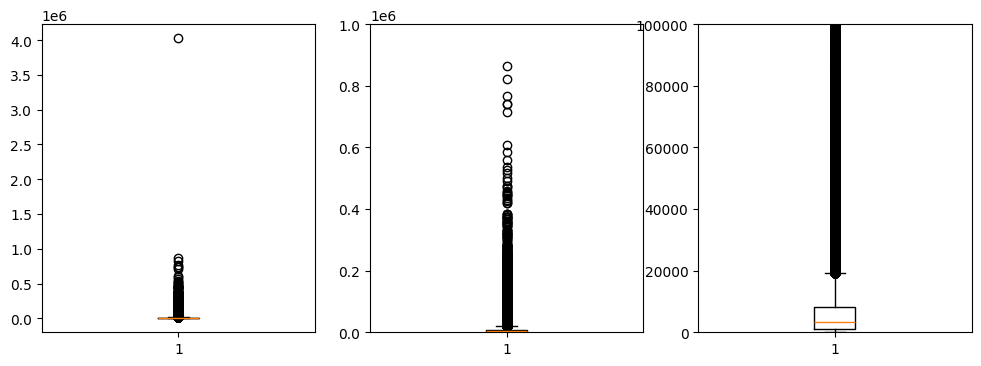

In [5]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.boxplot(df_train['UltimateIncurredClaimCost'])

plt.subplot(132)
plt.boxplot(df_train['UltimateIncurredClaimCost'])
plt.ylim(0, 1e6)

plt.subplot(133)
plt.boxplot(df_train['UltimateIncurredClaimCost'])
plt.ylim(0, 1e5)

plt.show()

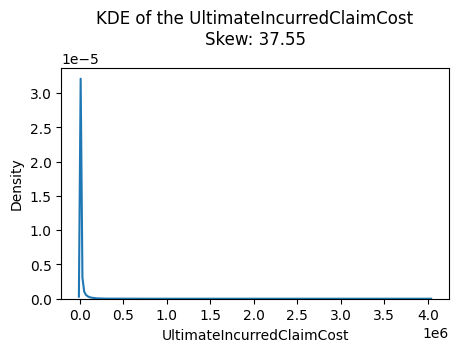

In [6]:
plt.figure(figsize=(5, 3))

sns.kdeplot(df_train['UltimateIncurredClaimCost'])
plt.title(f"KDE of the UltimateIncurredClaimCost\nSkew: { sp.stats.skew(df_train['UltimateIncurredClaimCost']):.2f}")

plt.show()

In [7]:
df_train.UltimateIncurredClaimCost.describe().astype(int)

count      54000
mean       11003
std        33390
min          121
25%          926
50%         3371
75%         8197
max      4027135
Name: UltimateIncurredClaimCost, dtype: int64

The target variable is extremely skewed, with 75% of the values falling under 9000 and the max value reaching as high as 4 million. Some transformation must be applied

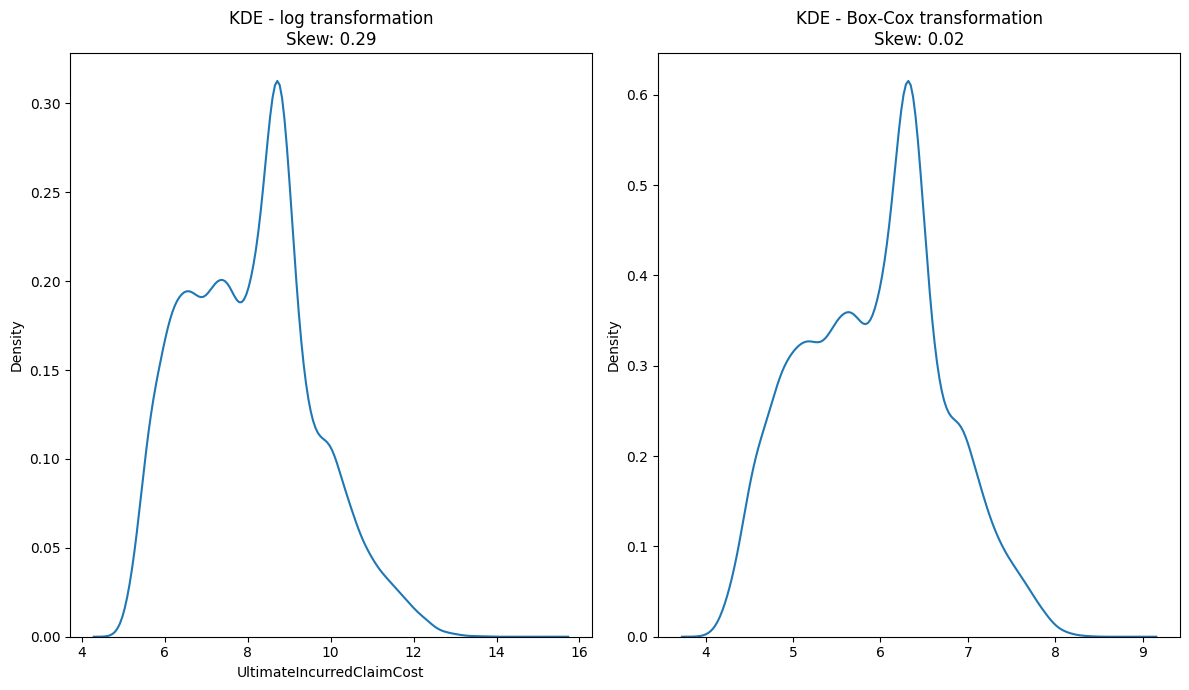

In [8]:
# looking for a suitable transformation for the target variable 

plt.figure(figsize=(12, 7))

# log transformation 
plt.subplot(121)
y_transformed = np.log(df_train['UltimateIncurredClaimCost'])
sns.kdeplot(y_transformed)
plt.title(f"KDE - log transformation\nSkew: { sp.stats.skew(y_transformed):.2f}")

# box-cox transform 
plt.subplot(122)
y_transformed, lambda_value = sp.stats.boxcox(df_train['UltimateIncurredClaimCost'])
sns.kdeplot(y_transformed)
plt.title(f"KDE - Box-Cox transformation\nSkew: { sp.stats.skew(y_transformed):.2f}")

plt.tight_layout()
plt.show()

In [9]:
ks_test = sp.stats.kstest(y_transformed, 'norm', args=(np.mean(y_transformed), np.std(y_transformed)))
print("\nKolmogorov-Smirnov Test:")
print(f"Statistic = {ks_test.statistic}, p-value = {ks_test.pvalue}")


Kolmogorov-Smirnov Test:
Statistic = 0.04920737692631605, p-value = 4.5162352754131786e-114


The Box-Cox transformation heavily reduced the skewness in the target variable, but still is not close to normality. I'll focused on the transformed version of the target variable rather than the raw one.

In [10]:
df_train['y_transformed'] = y_transformed

In [11]:
pd.concat([
    df_train['UltimateIncurredClaimCost'].describe().astype(int),
    df_train['y_transformed'].describe().astype(int)
], axis=1)


,UltimateIncurredClaimCost,y_transformed
count,54000,54000
mean,11003,5
std,33390,0
min,121,4
25%,926,5
50%,3371,6
75%,8197,6
max,4027135,8


### Age

<Axes: >

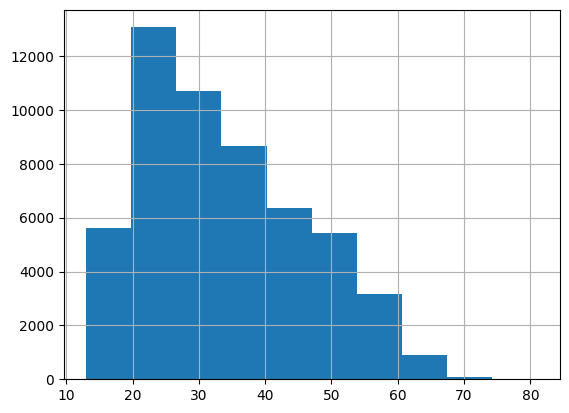

In [12]:
df_train['Age'].hist()


In [13]:
sc_minmax = MinMaxScaler()
sc_std = StandardScaler()

Text(0.5, 1.0, 'scatter plot: y_transormed and age scaled')

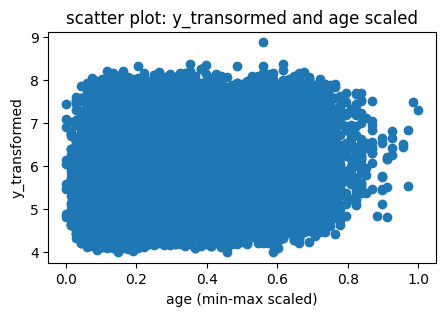

In [14]:
plt.figure(figsize=(5, 3))
plt.scatter(sc_minmax.fit_transform(df_train[['Age']]),
    y_transformed
)
plt.ylabel('y_transformed')
plt.xlabel('age (min-max scaled)')
plt.title('scatter plot: y_transormed and age scaled')

In [47]:
def corr(a, b):
    # simple aux function for cleaner prints
    return np.corrcoef(a, b)[0][1].round(3)

In [16]:
print('Correlation between age and y_transformed:', corr(sc_minmax.fit_transform(df_train[['Age']]).flatten(), df_train.y_transformed))

Correlation between age and y_transformed: 0.222


Weak correlation between Age and the target variable is weak. The scatterplot shows no clear relationship either

### Gender

<Axes: xlabel='Gender', ylabel='y_transformed'>

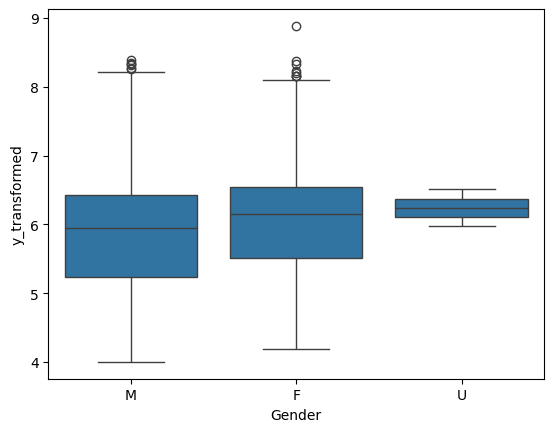

In [86]:
sns.boxplot(
    y=df_train['y_transformed'], 
    x=(df_train.Gender)
)

In [97]:
pd.concat([df_train.Gender.value_counts(), df_train.Gender.value_counts(normalize=True)], axis=1)

,count,proportion
Gender,,
M,41660,0.771481
F,12338,0.228481
U,2,0.000037


Even though the boxplot shows a big difference between gender U (unknown) and the other two, it only accounts for two samples. So no effect will be considered.

In [95]:
from scipy.stats import kruskal

kruskal_result = kruskal(
    df_train[df_train["Gender"] == "M"]["y_transformed"], 
    df_train[df_train["Gender"] == "F"]["y_transformed"]
)
print(f"Kruskal-Wallis p-value: {kruskal_result.pvalue:.5f}")

Kruskal-Wallis p-value: 0.00000


Gender is expected to have an effect on the target variable. When gender is U, it should be assigned to the majority value (M - 77%)

### MaritalStatus

<Axes: xlabel='MaritalStatus', ylabel='y_transformed'>

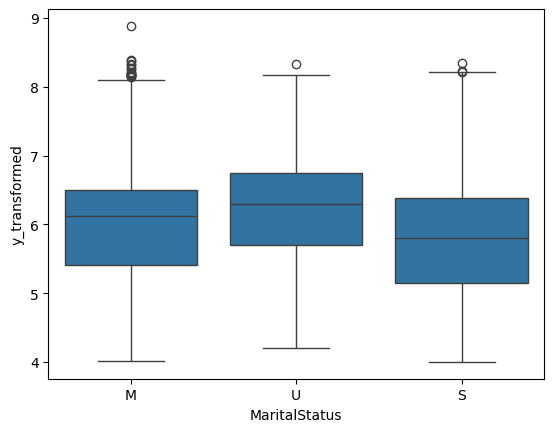

In [98]:
sns.boxplot(
    y=df_train['y_transformed'], 
    x=(df_train.MaritalStatus)
)

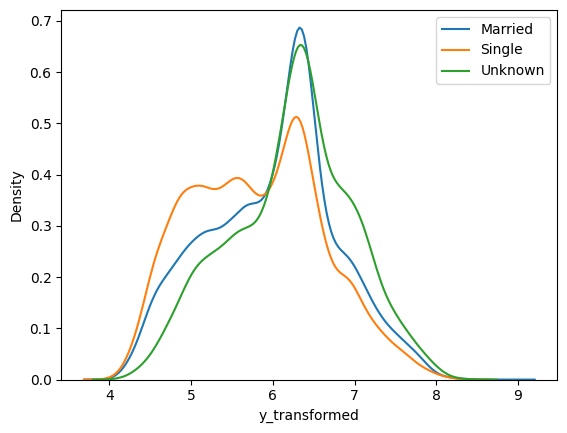

In [113]:
sns.kdeplot(df_train.loc[df_train.MaritalStatus == 'M', 'y_transformed'], label='Married')
sns.kdeplot(df_train.loc[df_train.MaritalStatus == 'S', 'y_transformed'], label='Single')
sns.kdeplot(df_train.loc[df_train.MaritalStatus == 'U', 'y_transformed'], label='Unknown')

plt.legend(loc='best')

In [100]:
pd.concat([
    df_train.MaritalStatus.value_counts(), 
    df_train.MaritalStatus.value_counts(normalize=True)
    ], axis=1)

,count,proportion
MaritalStatus,,
S,26161,0.484723
M,22516,0.417187
U,5294,0.098090


In [102]:
from scipy.stats import kruskal

kruskal_result = kruskal(
    df_train[df_train["MaritalStatus"] == "S"]["y_transformed"], 
    df_train[df_train["MaritalStatus"] == "M"]["y_transformed"],
    df_train[df_train["MaritalStatus"] == "U"]["y_transformed"]
)
print(f"Kruskal-Wallis p-value: {kruskal_result.pvalue:.5f}")

Kruskal-Wallis p-value: 0.00000


In [116]:
import scikit_posthocs as sp

# Perform Dunn’s test
dunn_result = sp.posthoc_dunn(df_train.fillna('U'), val_col="y_transformed", group_col="MaritalStatus", p_adjust="bonferroni")
print(dunn_result)


               M              S              U
M   1.000000e+00  4.094347e-157   4.890205e-70
S  4.094347e-157   1.000000e+00  2.440170e-255
U   4.890205e-70  2.440170e-255   1.000000e+00


### DependentChildren

In [17]:
pd.concat([
    df_train.DependentChildren.value_counts(normalize=False),
    df_train.DependentChildren.value_counts(normalize=True)
], axis=1)

,count,proportion
DependentChildren,,
0,50639,0.937759
2,1361,0.025204
1,1273,0.023574
3,528,0.009778
4,150,0.002778
5,42,0.000778
6,5,0.000093
9,1,0.000019
8,1,0.000019


94% of cases have DependantChildren = 0, so it will likely not be a determinant variable. I'll treat it as categorical to see if something can be observed (0, 1+)

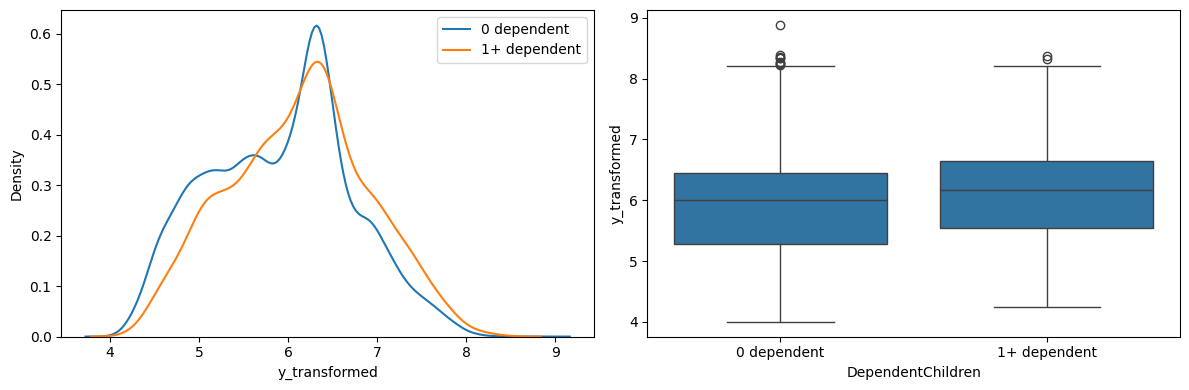

In [18]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(121)
sns.kdeplot(df_train.loc[df_train.DependentChildren == 0, 'y_transformed'], label='0 dependent', ax=axis[0])
sns.kdeplot(df_train.loc[df_train.DependentChildren > 0, 'y_transformed'], label='1+ dependent', ax=axis[0])
plt.legend(loc='best')

plt.subplot(122)
sns.boxplot(
    y=df_train['y_transformed'], 
    x=(df_train.DependentChildren > 0).replace({False: '0 dependent', True: '1+ dependent'})
, ax=axis[1])

plt.tight_layout()

A slight difference can be appreciated in he distributions

### DependentsOther

In [19]:
pd.concat([
    df_train.DependentsOther.value_counts(normalize=False),
    df_train.DependentsOther.value_counts(normalize=True)
], axis=1)

,count,proportion
DependentsOther,,
0,53506,0.990852
1,462,0.008556
2,23,0.000426
3,8,0.000148
5,1,0.000019


This variable is even more predominantly 0, with 99% of the samples. Won't be taken into account.

### WeeklyWages

In [20]:
df_train.WeeklyWages.describe()

count    54000.000000
mean       416.364807
std        248.638669
min          1.000000
25%        200.000000
50%        392.200000
75%        500.000000
max       7497.000000
Name: WeeklyWages, dtype: float64

<Axes: >

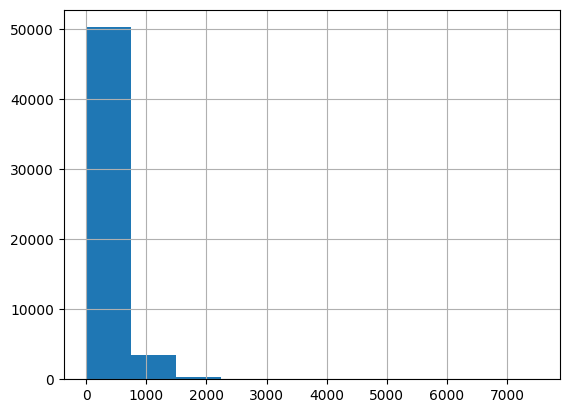

In [21]:
df_train['WeeklyWages'].hist()

Heavily skewed. Let's try a log transformation

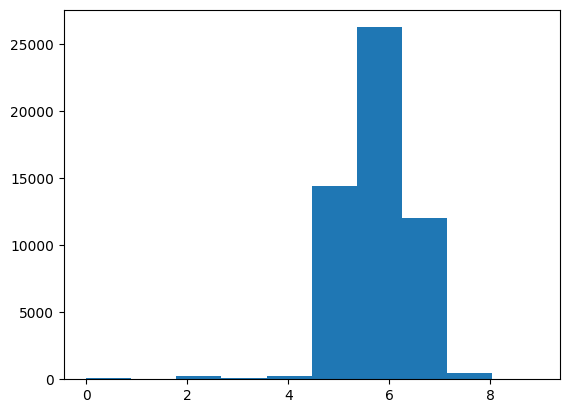

In [22]:
plt.hist(np.log(df_train['WeeklyWages']))
plt.show()

Text(0.5, 1.0, 'scatter plot: log(WeeklyWages) and y_transormed')

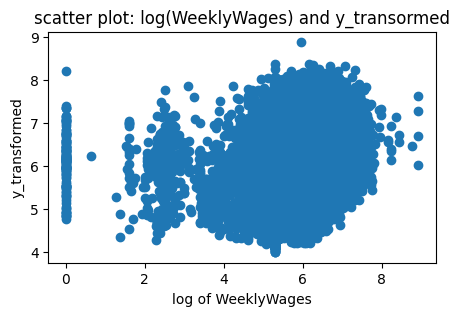

In [23]:
plt.figure(figsize=(5, 3))
plt.scatter(
    np.log(df_train['WeeklyWages']),
    df_train['y_transformed']
)
plt.ylabel('y_transformed')
plt.xlabel('log of WeeklyWages')
plt.title('scatter plot: log(WeeklyWages) and y_transormed')

values close to zero distribute along all the y axis, must probably represent no info

Text(0.5, 1.0, 'scatter plot: log(WeeklyWages) and y_transormed')

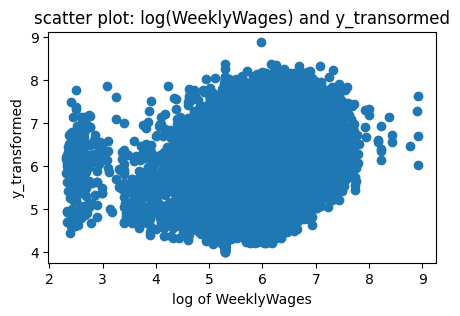

In [24]:
plt.figure(figsize=(5, 3))
plt.scatter(
    np.log(df_train.loc[df_train.WeeklyWages > 10, 'WeeklyWages']),
    df_train.loc[df_train.WeeklyWages > 10, 'y_transformed']
)
plt.ylabel('y_transformed')
plt.xlabel('log of WeeklyWages')
plt.title('scatter plot: log(WeeklyWages) and y_transormed')

This scatter shows some relationship, specially at higher wages

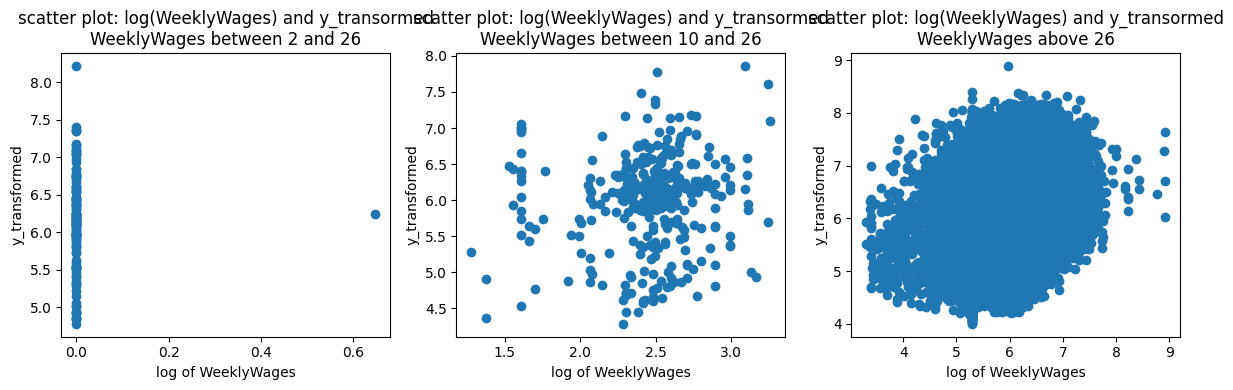

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(
    np.log(df_train.loc[df_train.WeeklyWages < 2, 'WeeklyWages']),
    df_train.loc[df_train.WeeklyWages < 2, 'y_transformed']
)
plt.ylabel('y_transformed')
plt.xlabel('log of WeeklyWages')
plt.title('scatter plot: log(WeeklyWages) and y_transormed\nWeeklyWages between 2 and 26')


plt.subplot(132)
plt.scatter(
    np.log(df_train.loc[(df_train.WeeklyWages > 2) & (df_train.WeeklyWages <= 26), 'WeeklyWages']),
    df_train.loc[(df_train.WeeklyWages > 2) & (df_train.WeeklyWages <= 26), 'y_transformed']
)
plt.ylabel('y_transformed')
plt.xlabel('log of WeeklyWages')
plt.title('scatter plot: log(WeeklyWages) and y_transormed\nWeeklyWages between 10 and 26')

plt.subplot(133)
plt.scatter(
    np.log(df_train.loc[df_train.WeeklyWages > 26, 'WeeklyWages']),
    df_train.loc[df_train.WeeklyWages > 26, 'y_transformed']
)
plt.ylabel('y_transformed')
plt.xlabel('log of WeeklyWages')
plt.title('scatter plot: log(WeeklyWages) and y_transormed\nWeeklyWages above 26')

plt.tight_layout()
plt.show()

In [26]:
print('Correlation between age and y_transformed:', 
      corr(np.log(df_train['WeeklyWages']), df_train['y_transformed']))

print('Correlation between age and y_transformed for WeeklyWages between 2 and 26:', 
      corr(
          np.log(df_train.loc[(df_train.WeeklyWages > 2) & (df_train.WeeklyWages <= 26), 'WeeklyWages']),
    df_train.loc[(df_train.WeeklyWages > 2) & (df_train.WeeklyWages <= 26), 'y_transformed']
    )
)

print('Correlation between age and y_transformed for WeeklyWages > 26:', 
      corr(
          np.log(df_train.loc[df_train.WeeklyWages > 26, 'WeeklyWages']),
            df_train.loc[df_train.WeeklyWages > 26, 'y_transformed'])
)

Correlation between age and y_transformed: 0.273
Correlation between age and y_transformed for WeeklyWages between 2 and 26: 0.096
Correlation between age and y_transformed for WeeklyWages > 26: 0.351


### PartTimeFullTime

In [196]:
df_train.PartTimeFullTime.value_counts()

PartTimeFullTime
F    49112
P     4888
Name: count, dtype: int64

<Axes: xlabel='PartTimeFullTime', ylabel='y_transformed'>

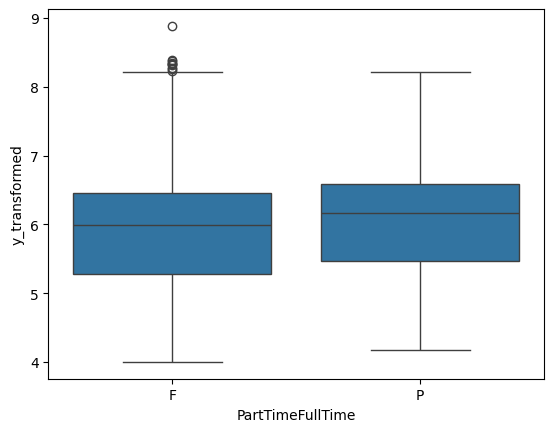

In [198]:
sns.boxplot(
    y=df_train['y_transformed'], 
    x=df_train.PartTimeFullTime
)

In [118]:
df_train.columns

Index(['ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'Age', 'Gender',
       'MaritalStatus', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost', 'y_transformed', 'Year', 'Month',
       'Residuals', 'DayOfWeek', 'DaysToReport'],
      dtype='object')

### HoursWorkedPerWeek

<Axes: xlabel='HoursWorkedPerWeek', ylabel='y_transformed'>

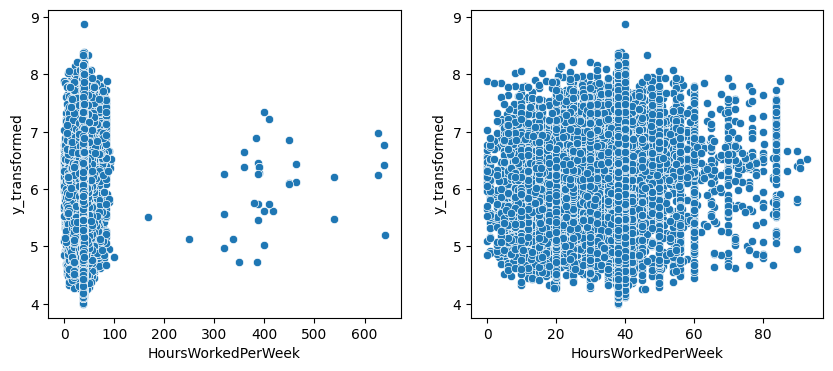

In [140]:
plt.figure(figsize=(10, 4))
plt.subplot(121)

sns.scatterplot(x=df_train['HoursWorkedPerWeek'], y=df_train.y_transformed)

plt.subplot(122)

sns.scatterplot(
    x=df_train.loc[df_train['HoursWorkedPerWeek'] < 100, 'HoursWorkedPerWeek'], 
    y=df_train.loc[df_train['HoursWorkedPerWeek'] < 100, 'y_transformed']
)



These variable appears very noisy, with values over 100, when ignoring those values, no clear relationship is evident either.

In [161]:
pd.cut(df_train.HoursWorkedPerWeek, [-np.inf, 20, 40, 60, np.inf])

HoursWorkedPerWeek
(20.0, 40.0]    48989
(-inf, 20.0]     2543
(40.0, 60.0]     2076
(60.0, inf]       392
Name: count, dtype: int64

<Axes: xlabel='HoursWorkedPerWeek', ylabel='y_transformed'>

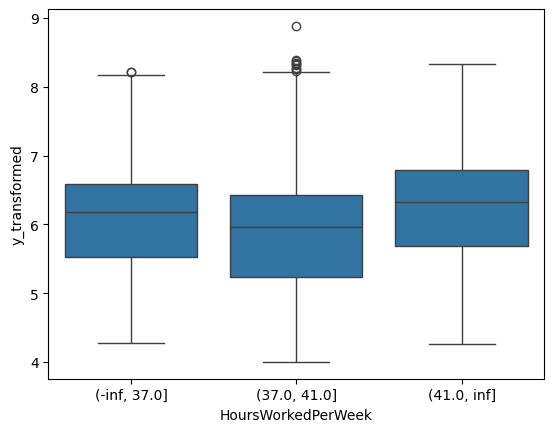

In [187]:
hww_buckets = [-np.inf, 37, 41, np.inf]

sns.boxplot(
    y=df_train['y_transformed'], 
    x=pd.cut(df_train.HoursWorkedPerWeek, hww_buckets)
)

In [189]:
pd.concat([
    pd.cut(df_train.HoursWorkedPerWeek, hww_buckets).value_counts(),
    pd.cut(df_train.HoursWorkedPerWeek, hww_buckets).value_counts(normalize=True)
], axis=1)

,count,proportion
HoursWorkedPerWeek,,
"(37.0, 41.0]",44984,0.833037
"(-inf, 37.0]",6615,0.122500
"(41.0, inf]",2401,0.044463


Quantizing the data allows me to infer workers with more `regular` work schedules would usually have less expensive claims, although most outliers fall into this category, which is also significantly larger

### DaysWorkedPerWeek

In [27]:
pd.concat([
    df_train.DaysWorkedPerWeek.value_counts(normalize=False), 
    df_train.DaysWorkedPerWeek.value_counts(normalize=True)
], axis=1).sort_index()

,count,proportion
DaysWorkedPerWeek,,
1,183,0.003389
2,513,0.009500
3,1436,0.026593
4,1476,0.027333
5,49185,0.910833
6,884,0.016370
7,323,0.005981


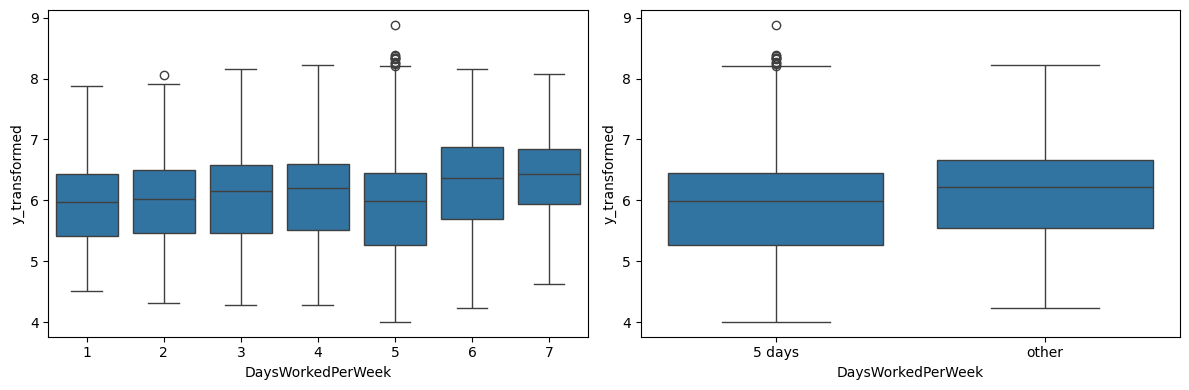

In [28]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(121)
sns.boxplot(
    y=df_train['y_transformed'], 
    x=df_train.DaysWorkedPerWeek
)

plt.subplot(122)
sns.boxplot(
    y=df_train['y_transformed'], 
    x=(df_train.DaysWorkedPerWeek != 5).replace({False: '5 days', True: 'other'})
, ax=axis[1])

plt.tight_layout()

A small difference appears between days, but the values other than 5 are so atomized that they are unlikely to make a difference. One approach would be to group them in two: 5 days (91%) and other arrangement

### InitialIncurredClaimCost

In [29]:
df_train.InitialIncurredCalimsCost.describe()

count    5.400000e+04
mean     7.841146e+03
std      2.058408e+04
min      1.000000e+00
25%      7.000000e+02
50%      2.000000e+03
75%      9.500000e+03
max      2.000000e+06
Name: InitialIncurredCalimsCost, dtype: float64

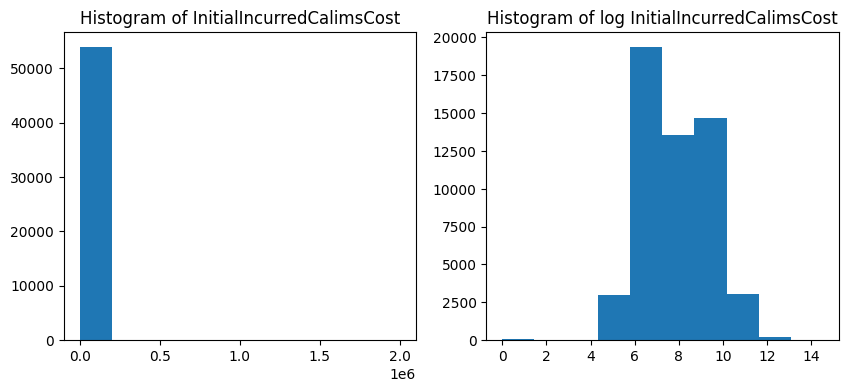

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(121)
plt.hist(df_train.InitialIncurredCalimsCost)
plt.title('Histogram of InitialIncurredCalimsCost')

plt.subplot(122)
plt.hist(np.log(df_train.InitialIncurredCalimsCost))
plt.title('Histogram of log InitialIncurredCalimsCost')

plt.show()

Text(0.5, 1.0, 'scatter plot: y_transormed and InitialIncurredCalimsCost')

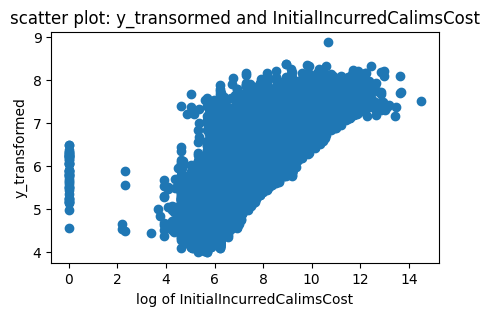

In [31]:
plt.figure(figsize=(5, 3))
plt.scatter(
    np.log(df_train.InitialIncurredCalimsCost),
    y_transformed
)
plt.ylabel('y_transformed')
plt.xlabel('log of InitialIncurredCalimsCost')
plt.title('scatter plot: y_transormed and InitialIncurredCalimsCost')

In [32]:
print('Correlation between InitialIncurredClaimsCost and y_transformed:',
      
    corr(
        np.log(df_train.InitialIncurredCalimsCost),
        y_transformed
    )
) 

print('Correlation between InitialIncurredClaimsCost and y_transformed, when InitialIncurredClaimsCost > 1:',
      
    corr(
        np.log(df_train.loc[df_train.InitialIncurredCalimsCost > 1, 'InitialIncurredCalimsCost']),
        df_train.loc[df_train.InitialIncurredCalimsCost > 1, 'y_transformed']
    )
) 

Correlation between InitialIncurredClaimsCost and y_transformed: 0.857
Correlation between InitialIncurredClaimsCost and y_transformed, when InitialIncurredClaimsCost > 1: 0.866


As expected, there is a strong correlation between the Initial Incurred Cost of the Claim and the Final one.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

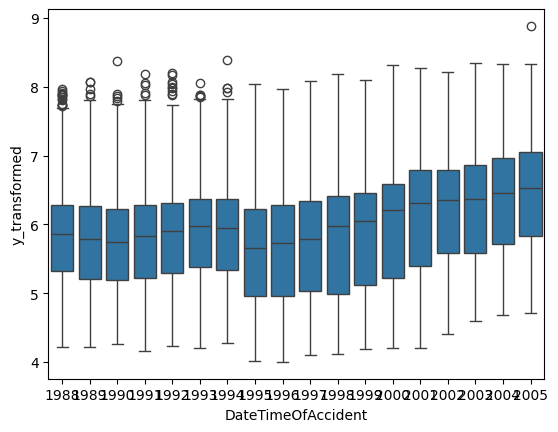

In [42]:
fig, ax = plt.subplots()
sns.boxplot(x=df_train['DateTimeOfAccident'].dt.year, y=df_train.y_transformed, ax=ax)

ax.get_xticks()

In [57]:
print('Correlation between year of DateTimeOfAccident and y_transformed:',
      
    corr(
        df_train['DateTimeOfAccident'].dt.year,
        df_train.y_transformed
    )
)

Correlation between year of DateTimeOfAccident and y_transformed: 0.237


In [53]:
from pymannkendall import original_test
trend, h, p, z, Tau, s, var_s, slope, intercept = original_test(df_train.sort_values('DateTimeOfAccident')["y_transformed"])
print(f"Trend: {trend}, p-value: {p}")

print(f'trend: {trend}, h: {h}, p: {p}, z: {z}, Tau: {Tau}, s: {s}, var_s: {var_s}, slope: {slope}, intercept: {intercept}')


Trend: increasing, p-value: 0.0
trend: increasing, h: True, p: 0.0, z: 55.739981559608125, Tau: 0.1599163091497579, s: 233153661.0, var_s: 17496485984999.0, slope: 1.245096565852456e-05, intercept: 5.672025545530695


In [54]:
import pandas as pd
import statsmodels.api as sm

# Ensure 'DateTimeOfAccident' is in datetime format

# Extract Year and Month
df_train["Year"] = df_train["DateTimeOfAccident"].dt.year
df_train["Month"] = df_train["DateTimeOfAccident"].dt.month

# Fit a linear regression model on Year
X = sm.add_constant(df_train["Year"])  # Add intercept
y = df_train["y_transformed"]

model = sm.OLS(y, X).fit()  # Ordinary Least Squares Regression
df_train["Residuals"] = model.resid  # Store residuals

# Now use 'Residuals' instead of 'y_transformed' to compare months!


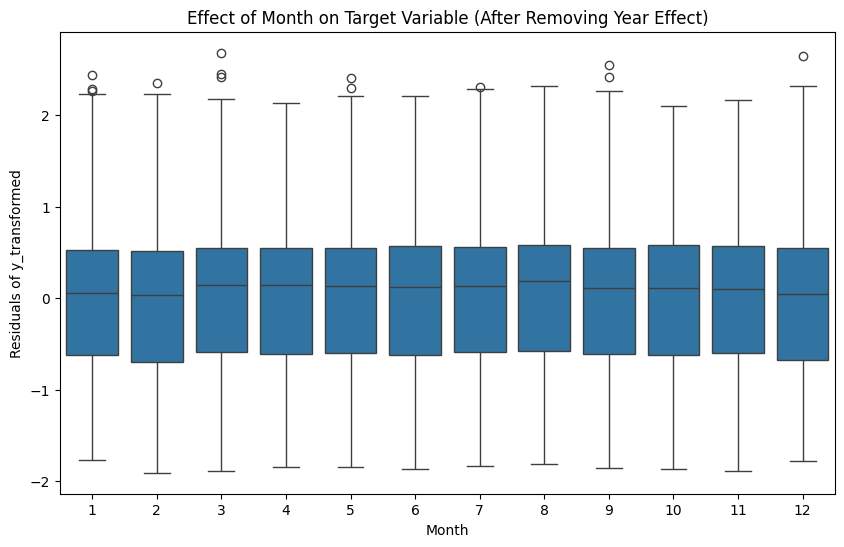

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train["Month"], y=df_train["Residuals"])
plt.title("Effect of Month on Target Variable (After Removing Year Effect)")
plt.xlabel("Month")
plt.ylabel("Residuals of y_transformed")
plt.show()


After accounting for year, months do not appear to have an independent effect on the target variable.

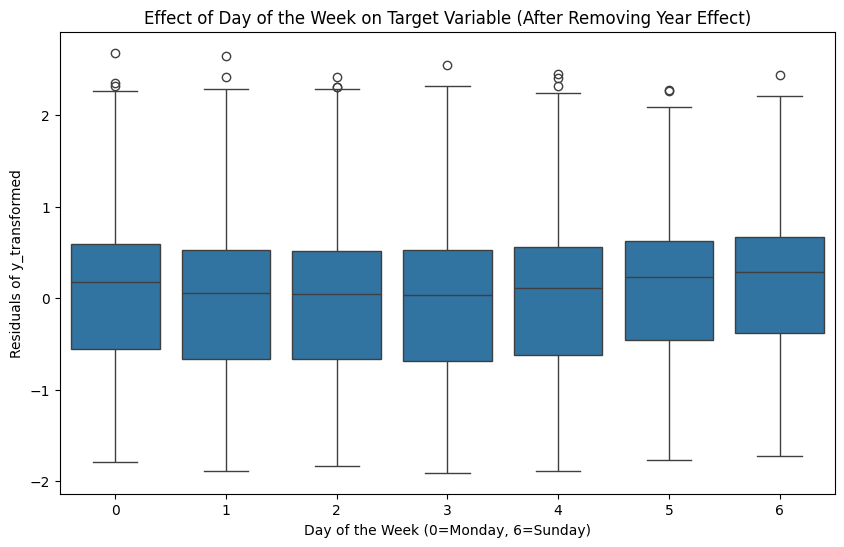

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train["DateTimeOfAccident"].dt.day_of_week, y=df_train["Residuals"])
plt.title("Effect of Day of the Week on Target Variable (After Removing Year Effect)")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Residuals of y_transformed")
plt.show()

In [60]:
import numpy as np

df_train['DayOfWeek'] = df_train["DateTimeOfAccident"].dt.day_of_week

ss_between = sum(df_train.groupby("DayOfWeek")["Residuals"].mean()**2) * len(df_train) / 7
ss_total = np.sum(df_train["Residuals"]**2)
eta_squared = ss_between / ss_total
print(f"Effect Size (η²): {eta_squared:.5f}")


Effect Size (η²): 0.01006


In [65]:
### DatesToReport

### DaysToReport

In [77]:
df_train['DaysToReport'] = (df_train['DateReported'] - df_train['DateTimeOfAccident']).dt.days + 1 # no zero values


Text(0.5, 1.0, 'scatter plot: DaysToReport and y_transormed')

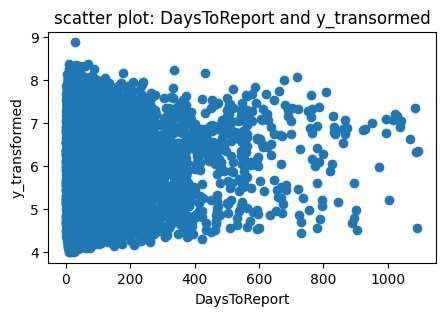

In [80]:
plt.figure(figsize=(5, 3))
plt.scatter(
    df_train.DaysToReport,
    y_transformed
)
plt.ylabel('y_transformed')
plt.xlabel('DaysToReport')
plt.title('scatter plot: DaysToReport and y_transormed')

While no linear relationship can be observed between the days to report and the target variable, it appears as if more extreme values were less likely to be seen as time passes. 

In [207]:
pd.cut(df_train.DaysToReport, [-np.inf, 50, 300, 500, np.inf]).value_counts()

DaysToReport
(-inf, 50.0]      43827
(50.0, 300.0]      9638
(300.0, 500.0]      340
(500.0, inf]        195
Name: count, dtype: int64

<Axes: xlabel='DaysToReport', ylabel='y_transformed'>

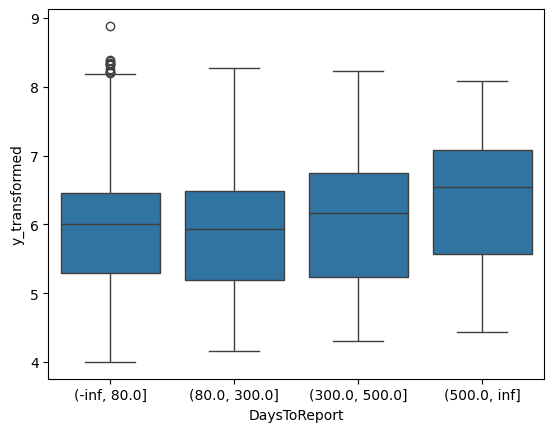

In [220]:
dtt_buckets = [-np.inf, 80, 300, 500, np.inf]

sns.boxplot(
    y=df_train['y_transformed'], 
    x=pd.cut(df_train.DaysToReport, dtt_buckets)
)

In [ ]:
pd.concat([
    pd.cut(df_train.DaysToReport, hww_buckets).value_counts(),
    pd.cut(df_train.DaysToReport, hww_buckets).value_counts(normalize=True)
], axis=1)

### ClaimDescription

In [193]:
df_train.ClaimDescription.value_counts()

ClaimDescription
SLIPPED ON ROLLER TENDONITIS RIGHT SHOULDER                      289
SORTING ALUMINIUM BARS STRAIN SHOULDER NECK                      278
SLIPPED USING LATHE IN EYE CORNEA                                258
REDBACK SPIDER BITE RIGHT FOOT RIGHT FRACTURE                    256
LIFTING TYRES LOWER BACK STRAIN                                  255
                                                                ... 
STRUCK SLICING MACHINE LACERATION INDEX FINGER                     1
STRUCK PIECE METAL BURN RIGHT HAND                                 1
SLIPPED ON FLOOR AND STRUCK HEAD STRAINED NECK                     1
TURNING PALLET PALLET JACK LACERATED RIGHT RING FINGER             1
CUT WITH BREAD KNIFE LACERATION LEFT INDEX AND MIDDLE FINGERS      1
Name: count, Length: 28114, dtype: int64

Since it has 28 thousand unique values and involves descriptions, it will be treated with NLP in its own study. 